# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 3 - Validation of various potentials**


### **Exercise 1: Validation of generated potentials using pyiron based workflows**

Before the excercise, you should:

* Have run the notebooks from day 1 and day2
* Be familiar with working with pyiron and the basics of potential fitting

The aim of this exercise is to make you familiar with:

* Potential validation workflows

## **Importing the modules and creating the project**

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project

In [4]:
pr = Project("validation")

In [5]:
# The good potentials already added to the pyiron database

potential_list  = ['2012--Mendelev-M-I--Cu--LAMMPS--ipr1', '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2', 'Cu-ace', 'Cu-runner-df4'] #, 'Cu-runner-df1']


## **Step 1: Get the equilibrium Cu lattice constant determined by the potentials**

First we compute energy-volume curves to get the equilibrium lattice constants determined by each potential

In [23]:
# Necessary to remove wierd characters in the potential name
def clean_project_name(name):
    return name.replace("-", "_")

2021-03-08 21:57:02,754 - pyiron_log - WARNING - The job murn_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


Potential:  Cu-ace


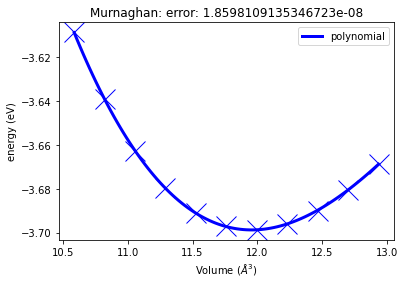

2021-03-08 21:57:04,391 - pyiron_log - WARNING - The job murn_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


Potential:  Cu-runner-df4


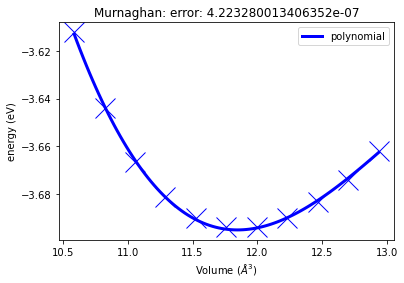

In [24]:
for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.create_ase_bulk("Cu")
    job_ref.potential = pot
    job_ref.calc_minimize()
    murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, "murn_job")
    murn_job.run()
    print("Potential: ", pot)
    murn_job.plot()

In [11]:
murn_job["output/equilibrium_energy"]

-3.694888787063416

In [29]:
# Define functions to get data

# Only work with Murnaghan jobs
def get_only_murn(job_table):
    return job_table.hamilton == "Murnaghan"

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["ref_job/input/potential/Name"]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

In [26]:
# Compile data using pyiron tables
table = pr.create_table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()
data_murn = table.get_dataframe()
data_murn

100%|██████████| 2/2 [00:00<00:00, 21.14it/s]

The job table_murn was saved and received the ID: 4449


,job_id,potential,a,eq_vol,eq_bm,eq_energy,n_atoms
0,4389,Cu-ace,3.629863,11.956678,146.220099,-3.698781,1
1,4401,Cu-runner-df4,3.618770,11.847397,145.857176,-3.694889,1


## **Compute elastic constants**

Using the equilibrium lattice constant, compute the elastic constant matrix using the automated workflow

In [27]:
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    print(pot)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_minimize()
    elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, "elastic_job")
    elastic_job.input["eps_range"] = 0.05
    elastic_job.run()

Cu-ace


2021-03-08 21:59:19,128 - pyiron_log - WARNING - The job elastic_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


Cu-runner-df4


2021-03-08 21:59:20,260 - pyiron_log - WARNING - The job elastic_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


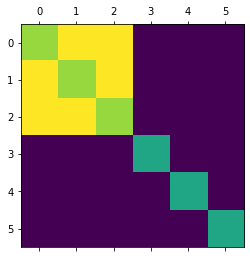

In [28]:
# Inspecting the elastic matrix
plt.matshow(elastic_job["output/elasticmatrix"]["C"]);

In [31]:
# Define functions to compute them in a table

# Only operate on ElasticMatrix jobs
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding lattice constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [32]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

table.run()
data_elastic = table.get_dataframe()
data_elastic

  0%|          | 0/2 [00:00<?, ?it/s]

The job table_elastic was saved and received the ID: 4450


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


,job_id,potential,C11,C12,C44
0,4414,Cu-ace,182.054447,132.575877,81.049351
1,4428,Cu-runner-df4,143.473893,170.027784,100.953889


## **Compare computed elastic constants with that from DFT calculations**

Comparing the computing elastic constant values with DFT benchmarks from the http://atomistictools.org/ database 

In [41]:
# Querying the database http://atomistictools.org/ from using the API interface

from structdbrest import StructDBLightRester
rest = StructDBLightRester(token="workshop2021")

# Querying calculations done using the FHI-AIMS (https://aimsclub.fhi-berlin.mpg.de/) DFT code
fhi_calc = rest.query_calculator_types("FHI%aims%")[0]

# Querying for elastic properties
dft_elast_prop = rest.query_properties(rest.PropertyTypes.ELASTIC_MATRIX, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

# Querying for phonon properties
dft_phon_prop = rest.query_properties(rest.PropertyTypes.PHONONS, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

Querying...done
Response successful, size = 7.20 kB, time = 0.17 s
1  entries received
Querying...done
Response successful, size = 37.78 kB, time = 0.38 s
1  entries received
Querying...done
Response successful, size = 22.50 kB, time = 0.19 s
1  entries received


In [34]:
C_dft = dft_elast_prop.value["C"]
print("DFT C11={:.1f} GPa".format(C_dft[0][0]))
print("DFT C12={:.1f} GPa".format(C_dft[0][1]))
print("DFT C44={:.1f} GPa".format(C_dft[3][3]))

DFT C11=176.9 GPa
DFT C12=131.7 GPa
DFT C44=82.5 GPa


## **Calculation of surface energies**

We can also use the potentials to calculate the surface energies of the Cu (111), (110), and (100) surfaces

In [36]:

surface_type_list = ["fcc111", "fcc110", "fcc100"]

for i, pot in enumerate(data_murn.potential.to_list()):
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    a = data_murn.a.to_list()[i]
    for surface_type in surface_type_list:
        surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
        job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
        job_lammps.structure = surface
        job_lammps.potential = pot
        job_lammps.calc_minimize()
        job_lammps.run()

2021-03-08 22:09:35,929 - pyiron_log - WARNING - The job surf_fcc111 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 22:09:37,202 - pyiron_log - WARNING - The job surf_fcc110 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 22:09:38,486 - pyiron_log - WARNING - The job surf_fcc100 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 22:09:39,928 - pyiron_log - WARNING - The job surf_fcc111 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 22:09:41,277 - pyiron_log - WARNING - The job surf_fcc110 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 22:09:42,612 - pyiron_log - WARNING - The job surf_fcc100 is being loaded instead of running. To re-run use the argument 'de

In [38]:
# Function to filter only surface calculations
def is_a_surface(job_table):
    return (job_table.hamilton == "Lammps") & (job_table.job.str.contains("fcc")) & (job_table.status == "finished")

def get_potential_lammps_job(job_path):
    return job_path["input/potential/Name"]

def get_surface_type(job_path):
    surf_list =  ["fcc111", "fcc110", "fcc100"]
    conditions = [val in job_path.job_name for val in surf_list]
    return surf_list[np.where(conditions)[0].tolist()[0]]

def get_area(job_path):
    cell = job_path["output/structure/cell/cell"]
    return np.linalg.norm(np.cross(cell[0], cell[1]))

In [39]:
table = pr.create_table("table_surface", delete_existing_job=True)
table.db_filter_function = is_a_surface
table.add["potential"] = get_potential_lammps_job
table.add["surface_type"] = get_surface_type
table.add["surface_area"] = get_area
table.add.get_total_number_of_atoms

table.add.get_energy_tot
table.run()
data_surf = table.get_dataframe()
data_surf

 67%|██████▋   | 4/6 [00:00<00:00, 38.35it/s]

The job table_surface was saved and received the ID: 4451


100%|██████████| 6/6 [00:00<00:00, 38.42it/s]


,Number_of_atoms,job_id,energy_tot,potential,surface_type,surface_area
0,512,4443,-1834.286336,Cu-ace,fcc111,365.141308
1,512,4444,-1775.620101,Cu-ace,fcc110,596.273259
2,512,4445,-1814.469585,Cu-ace,fcc100,421.628865
3,512,4446,-1835.853699,Cu-runner-df4,fcc111,362.913030
4,512,4447,-1786.742960,Cu-runner-df4,fcc110,592.634496
5,512,4448,-1816.715931,Cu-runner-df4,fcc100,419.055871


Compute surface energies using data from the bulk fcc crystal

In [40]:
data_merged = pd.merge(data_surf, data_murn, on="potential")
data_merged["surface_energy"] = data_merged.energy_tot - (data_merged.eq_energy * data_merged.Number_of_atoms)
data_merged["surface_energy_in_mJ_per_sq_m"] = data_merged.surface_energy / data_merged.surface_area / 2 * 16.0219 * 1e3
data_merged[["potential", "surface_type", "surface_energy_in_mJ_per_sq_m"]]

,potential,surface_type,surface_energy_in_mJ_per_sq_m
0,Cu-ace,fcc111,1305.155196
1,Cu-ace,fcc110,1587.423774
2,Cu-ace,fcc100,1506.815901
3,Cu-runner-df4,fcc111,1234.585883
4,Cu-runner-df4,fcc110,1419.881876
5,Cu-runner-df4,fcc100,1435.033014


## **Finite temperature thermodynamics (Harmonic approximation)**

We can also compute free energies and other finite temperature thermodynamic properties within the Harmonic approximation using phonopy (http://phonopy.github.io)

In [42]:
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_static()
    phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, "phonopy_job")
    phonopy_job.run()

The job phonopy_job was saved and received the ID: 4452
The job ref_job_0 was saved and received the ID: 4453
The job phonopy_job was saved and received the ID: 4454
The job ref_job_0 was saved and received the ID: 4455


Plotting the thermodynamic properties using phonopy

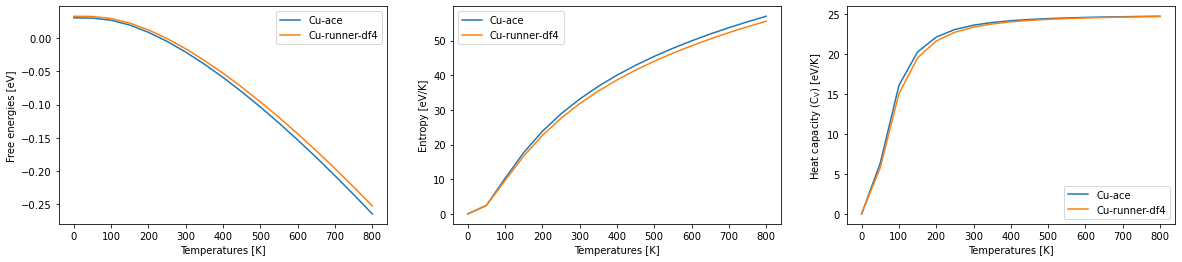

In [57]:
fig, ax_list = plt.subplots(ncols=3, nrows=1, sharex="row")
fig.set_figwidth(20)
#fig.set_figheight(20)


for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    
    ax = ax_list[0]
    ax.plot(thermo.temperatures, thermo.free_energies, label=pot)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Free energies [eV]")
    
    ax = ax_list[1]
    ax.plot(thermo.temperatures, thermo.entropy, label=pot)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Entropy [eV/K]")
    
    ax = ax_list[2]
    ax.plot(thermo.temperatures, thermo.cv, label=pot)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Heat capacity (C$_\mathrm{V}$) [eV/K]")
    
ax_list[0].legend()
ax_list[1].legend()
ax_list[2].legend()

fig.subplots_adjust(wspace=0.2);    

We can also compute the phonon density of states and compare with that from benchmarked DFT calculations

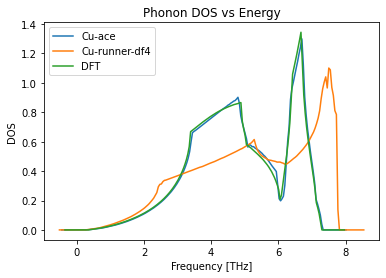

In [58]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex="row")

for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    phonopy_job.plot_dos(label=pot, ax=ax)
ax.plot(dft_phon_prop.value["dos_energies"],  dft_phon_prop.value["dos_total"], label="DFT")
ax.legend();

## **Validating against original dataset**

Finally we see how well the potentials reproduce the energies and forces from the dataset they are fit on

In [50]:
pr_import = Project("../datasets")
if len(pr_import.job_table()) == 0:
    pr_import.unpack("Cu_training_archive")

In [51]:
pr_import.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,4456,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/Cu_database/,2021-02-08 10:33:52.341472,None,None,zora@cmti001#1,GenericJob,0.4,None,None
1,4457,finished,None,df3_10k,/df3_10k,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/Cu_database/,2021-02-08 10:33:53.993230,None,None,zora@cmti001#1,GenericJob,0.4,None,None
2,4458,finished,None,df2_1k,/df2_1k,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/Cu_database/,2021-02-08 10:33:54.435308,None,None,zora@cmti001#1,GenericJob,0.4,None,None


In [ ]:
container = pr_import.load("df1_A1_A2_A3_EV_elast_phon")

In [ ]:
container.to_pandas()

Now we iterate over the structures in the dataset and compute the energies and forces for comparison

In [ ]:
structure_list, energy_list, force_list, num_atoms_list =  container.to_list()

energy_per_atom_list = np.array(energy_list) / np.array(num_atoms_list)


In [ ]:
energy_pred_dict = dict()
force_pred_dict = dict()

for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    energy_pred_list = list()
    force_pred_list = list()
    
    stride = 10
    for i, struct in enumerate(structure_list[::stride]):
        job = pr_pot.create_job(pr.job_type.Lammps, "lammps_struct_{}".format(i))
        job.potential = pot
        job.structure = struct
        job.calc_static()
        job.run()
        energy_pred_list.append(job["output/generic/energy_tot"][-1] / len(struct))
        force_pred_list.append(job["output/generic/forces"][-1])
    job_box = pr_pot.create_job(pr.job_type.Lammps, "lammps_box")
    job_box.potential = pot
    job_box.structure = pr_pot.create_atoms("Cu", scaled_positions=[[0.5, 0.5, 0.5]], cell=np.eye(3)*10, pbc=True)
    job_box.calc_static()
    job_box.run()
    if "runner" in pot:
        energy_pred_list = np.array(energy_pred_list)
        
    # correct for energy of isolated atom (no need for NN potentials)
    else:
        energy_pred_list = np.array(energy_pred_list) - job_box["output/generic/energy_tot"][-1]
        
    energy_pred_dict[pot] = energy_pred_list
    force_pred_dict[pot] = force_pred_list

In [ ]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=2, sharey="row", sharex="row")
fig.set_figwidth(18)
fig.set_figheight(12)

for i, (pot, energy_pred) in enumerate(energy_pred_dict.items()):
    
    ax = ax_list[0][i]
    ax.plot(energy_per_atom_list[::stride], energy_pred, "x")
    ax.plot(energy_per_atom_list[::stride], energy_per_atom_list[::stride])
    ax.set_title(pot + " (Energies)")
    ax.set_xlabel("Energy DFT [eV]")
    ax.set_ylabel("Energy pred [eV]")
    
    ax = ax_list[1][i]
    force_orig = np.hstack([f.flatten() for f in force_list[::stride]])
    force_pred = np.hstack([f.flatten() for f in force_pred_dict[pot]])
    
    ax.plot(force_orig, force_pred, "x")
    ax.plot(force_orig, force_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Forces)")
    
fig.subplots_adjust(wspace=0.1, hspace=0.2)
